### References

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

Try with different batch sizes.

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

### Prepare to load images

In [3]:
data_dir = pathlib.Path('gtsrb/train_images/')
signs = list(data_dir.glob('00001/*'))
  
classNames = np.array(os.listdir(data_dir))
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

### Auxiliary functions 

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Loading images takes place in here

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("gtsrb/train_images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



### Information about image shape and size of training set

In [6]:
for image, label in dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  
dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1
print("Total images in dataset: ",dataset_length)


Image shape:  (32, 32, 3)
Total images in dataset:  39209


### Preparing dataset

In [7]:
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size = dataset_length)
dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.repeat()

### Loading and preparing test dataset

In [8]:
testset = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)


### Show a batch of training images

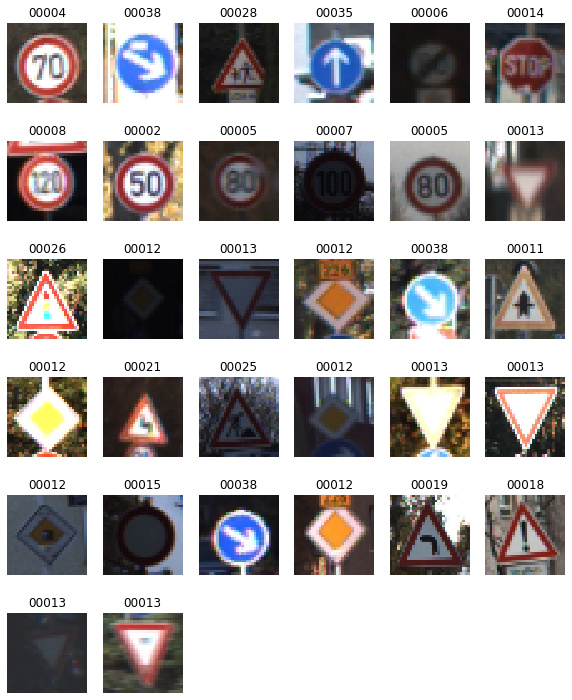

In [9]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(dataset))        
show_batch(image_batch, label_batch.numpy())

### Build a simple network

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

def cnn55D3L2FC(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(imgSize, imgSize, channels),
                     activation='relu'))                     
    model.add(Conv2D(32, (3, 3), activation='relu') ) 
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

model = cnn55D3L2FC(43, 32, 3)


### Draw a diagram of the network

This requires installing some packages, namely graphviz

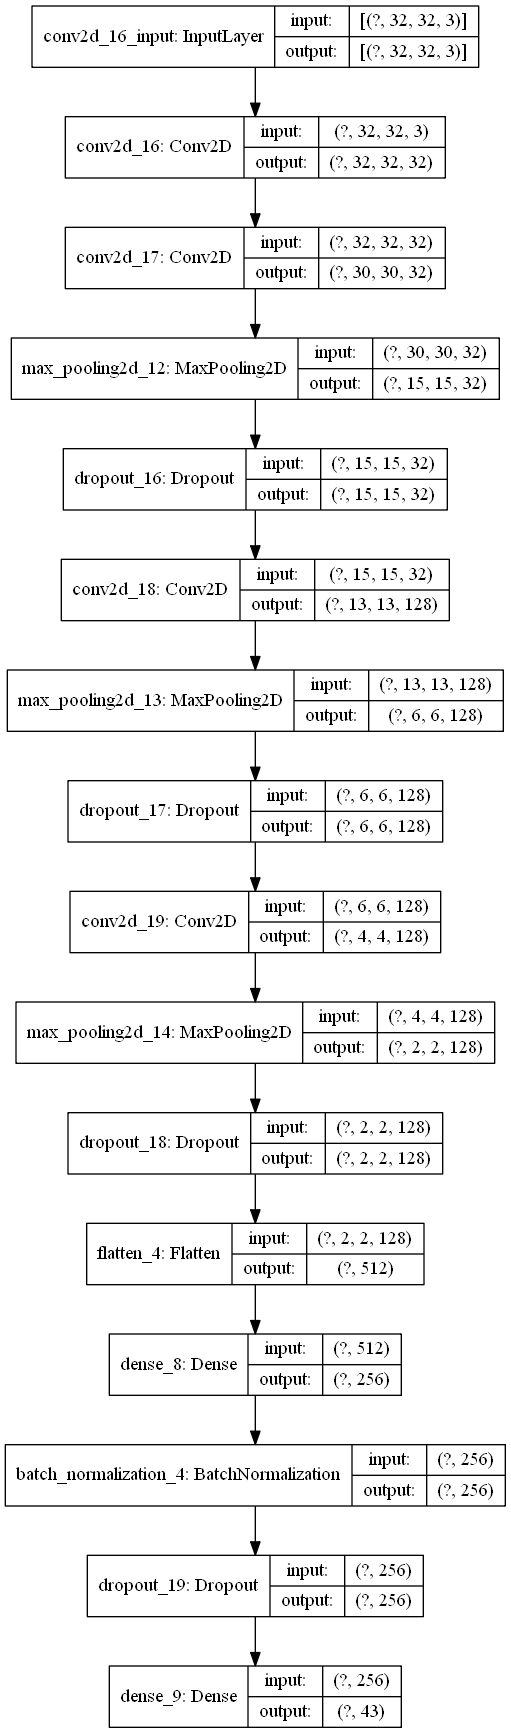

In [39]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### Display a table with model information

When building a model kee an eye on the number of trainable parameters. Try to keep it below 10 million

In [40]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 128)       36992     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 6, 6, 128)        

### Perform a random split to create a validation set

Note that due to the way the GTSRB is build (using video sequences) this is not an ideal approach. Try to partition the set manually, selecting a few sequences for validation purposes. Load the training and validation sets independently.

In [41]:
train_size = int(0.8 * dataset_length)
val_size = int(0.2 * dataset_length)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(val_size)

### Train the network 

In [42]:
history = model.fit(dataset, steps_per_epoch = 0.8*dataset_length/BATCH_SIZE,
          epochs=20, validation_data = val_dataset, validation_steps= 0.2*dataset_length/BATCH_SIZE)

Train for 980.225 steps, validate for 245.05625 steps
Epoch 1/20
981/980 [==============================] - 9s 10ms/step - loss: 1.8475 - categorical_accuracy: 0.4819 - val_loss: 0.3147 - val_categorical_accuracy: 0.9153
Epoch 2/20
981/980 [==============================] - 9s 9ms/step - loss: 0.4071 - categorical_accuracy: 0.8725 - val_loss: 0.0935 - val_categorical_accuracy: 0.9737
Epoch 3/20
981/980 [==============================] - 9s 9ms/step - loss: 0.2298 - categorical_accuracy: 0.9283 - val_loss: 0.0413 - val_categorical_accuracy: 0.9895
Epoch 4/20
981/980 [==============================] - 9s 9ms/step - loss: 0.1648 - categorical_accuracy: 0.9481 - val_loss: 0.0286 - val_categorical_accuracy: 0.9936
Epoch 5/20
981/980 [==============================] - 9s 9ms/step - loss: 0.1379 - categorical_accuracy: 0.9565 - val_loss: 0.0139 - val_categorical_accuracy: 0.9957
Epoch 6/20
981/980 [==============================] - 9s 9ms/step - loss: 0.1216 - categorical_accuracy: 0.9613 - v

### Plot the training history

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


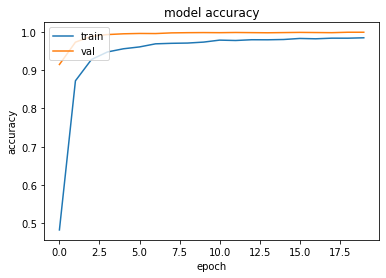

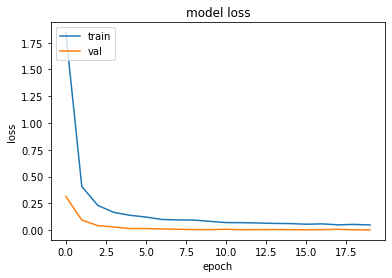

In [43]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate the model on the test set

This is the accuracy number that really matters

In [44]:
model.evaluate(testset)

395/395 [==============================] - 4s 10ms/step - loss: 0.0556 - categorical_accuracy: 0.9830


[0.05556910569266735, 0.98297703]